### Normalizing Histone Signals

In [2]:
import pandas as pd

# Load the dataset
file_path = "/Users/faith/Desktop/BIO1018-Chromatin-Accessibility-ML/data/final_feature_matrix.csv"
df = pd.read_csv(file_path)

# Extract histone marks columns (assuming the column names are known)
features = ["H3K4me1", "H3K4me3", "H3K27ac", "H3K27me3", "H3K9me3", "H3K36me3", "ESR1_signal", "FOXA1_signal", "GATA3_signal"]

# Describe the histone marks to check their distribution
feature_stats = df[features].describe()

feature_stats

,H3K4me1,H3K4me3,H3K27ac,H3K27me3,H3K9me3,H3K36me3,ESR1_signal,FOXA1_signal,GATA3_signal
count,2.805747e+06,2.805747e+06,2.805747e+06,2.805747e+06,2.805747e+06,2.805747e+06,2.805747e+06,2.805747e+06,2.805747e+06
mean,9.284954e-01,1.619672e+00,1.876460e+00,4.284724e-01,3.267553e-01,5.210774e-01,1.474908e+00,1.019349e+00,3.090687e-01
std,3.873447e+00,1.450186e+01,1.610315e+01,1.078472e+00,6.554833e-01,1.607422e+00,5.757240e+01,2.961572e+01,1.654903e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.951391e-02,5.728266e-02,2.143730e-02,6.359958e-02,6.878579e-02,5.405681e-02,7.023200e-02,9.806640e-02,7.474053e-02
50%,5.903432e-02,1.048672e-01,4.698577e-02,1.653574e-01,1.522299e-01,1.066401e-01,1.666346e-01,2.314697e-01,1.574655e-01
75%,2.174493e-01,1.686104e-01,1.078025e-01,3.871549e-01,3.276268e-01,2.416798e-01,3.494827e-01,4.479365e-01,3.027141e-01
max,2.353819e+02,5.857773e+02,6.556597e+02,1.448525e+02,6.892392e+01,1.978991e+02,2.230684e+04,3.770827e+04,3.097888e+02


### Baseline LOCO-CV (Extra Trees, Histogram Boosting)

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    matthews_corrcoef, brier_score_loss, roc_auc_score, 
    f1_score, precision_score, recall_score
)
from sklearn.ensemble import HistGradientBoostingClassifier, ExtraTreesClassifier
from sklearn.model_selection import StratifiedKFold

# Load dataset
file_path = "/Users/faith/Desktop/BIO1018-Chromatin-Accessibility-ML/data/final_feature_matrix.csv"
columns = ["chromosome", "Start", "End", "chromatin_state", "H3K4me1", "H3K4me3", "H3K27ac", 
           "H3K27me3", "H3K9me3", "H3K36me3", "ESR1_signal", "FOXA1_signal", "GATA3_signal"]

df = pd.read_csv(file_path, sep=",", names=columns)

# Ensure chromatin_state is numeric
df["chromatin_state"] = pd.to_numeric(df["chromatin_state"], errors="coerce")
df = df.dropna(subset=["chromatin_state"])
df["chromatin_state"] = df["chromatin_state"].astype(int)

# Select chromosome for leave-out
leave_out_chromosome = "chr1"  # Change this manually if needed

# Check unique chromosome names in dataset
print("Unique Chromosomes in Dataset:", df["chromosome"].unique())

# Split data: Leave out the chosen chromosome for testing
train_df = df[df["chromosome"] != leave_out_chromosome]
test_df = df[df["chromosome"] == leave_out_chromosome]

# Check class balance in the test set
print(f"\nClass distribution in left-out chromosome {leave_out_chromosome}:")
print(test_df["chromatin_state"].value_counts())

# Undersample majority class in training set (5× the minority class)
minority_class = train_df[train_df["chromatin_state"] == 1]
majority_class = train_df[train_df["chromatin_state"] == 0].sample(n=min(len(minority_class) * 5, len(train_df[train_df["chromatin_state"] == 0])), random_state=42)

train_df_balanced = pd.concat([minority_class, majority_class]).sample(frac=1, random_state=42)

# Extract Features & Target
feature_columns = ["H3K4me1", "H3K4me3", "H3K27ac", "H3K27me3", "H3K9me3", "H3K36me3",
                   "ESR1_signal", "FOXA1_signal", "GATA3_signal"]

X_train = train_df_balanced[feature_columns]
y_train = train_df_balanced["chromatin_state"]

X_test = test_df[feature_columns]
y_test = test_df["chromatin_state"]

# Apply MinMaxScaler to ALL features together (histones + TFs)
scaler = MinMaxScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Define models
models = {
    "Extra Trees": ExtraTreesClassifier(n_estimators=512, random_state=42),
    "Histogram Gradient Boosting": HistGradientBoostingClassifier(max_depth=5, random_state=42)
}

classification_threshold = 0.3  # Adjust classification threshold

# Store results
results = []

# Stratified K-Fold Cross-Validation (K=10)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():
    print(f"\nTraining {model_name} with 5-fold Stratified Cross-Validation...")

    fold_metrics = {
        "MCC": [], "Brier Score": [], "AUC": [], 
        "F1 Score": [], "Precision": [], "Recall": []
    }

    for train_idx, val_idx in kf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_fold_train, y_fold_train)

        # Predict probabilities
        y_val_probs = model.predict_proba(X_fold_val)[:, 1]
        y_val_pred = (y_val_probs > classification_threshold).astype(int)

        # Compute Metrics
        fold_metrics["MCC"].append(matthews_corrcoef(y_fold_val, y_val_pred))
        fold_metrics["Brier Score"].append(brier_score_loss(y_fold_val, y_val_probs))
        fold_metrics["AUC"].append(roc_auc_score(y_fold_val, y_val_probs))
        fold_metrics["F1 Score"].append(f1_score(y_fold_val, y_val_pred, zero_division=0))
        fold_metrics["Precision"].append(precision_score(y_fold_val, y_val_pred, zero_division=0))
        fold_metrics["Recall"].append(recall_score(y_fold_val, y_val_pred, zero_division=0))

    # Final model training on full training set
    model.fit(X_train, y_train)

    # Test model on the holdout test set (Chromosome 1)
    y_test_probs = model.predict_proba(X_test)[:, 1]
    y_test_pred = (y_test_probs > classification_threshold).astype(int)

    test_mcc = matthews_corrcoef(y_test, y_test_pred)
    test_brier = brier_score_loss(y_test, y_test_probs)
    test_auc = roc_auc_score(y_test, y_test_probs)
    test_f1 = f1_score(y_test, y_test_pred, zero_division=0)
    test_precision = precision_score(y_test, y_test_pred, zero_division=0)
    test_recall = recall_score(y_test, y_test_pred, zero_division=0)

    # Store results
    results.append({
        "Model": model_name,
        "Chromosome": leave_out_chromosome,
        "MCC": np.mean(fold_metrics["MCC"]),
        "Brier Score": np.mean(fold_metrics["Brier Score"]),
        "AUC": np.mean(fold_metrics["AUC"]),
        "F1 Score": np.mean(fold_metrics["F1 Score"]),
        "Precision": np.mean(fold_metrics["Precision"]),
        "Recall": np.mean(fold_metrics["Recall"]),
        "Test MCC": test_mcc,
        "Test Brier Score": test_brier,
        "Test AUC": test_auc,
        "Test F1 Score": test_f1,
        "Test Precision": test_precision,
        "Test Recall": test_recall,
    })

    # Print classification report
    print(f"\nEvaluation for {model_name} on Chromosome {leave_out_chromosome}:")
    print(f"Test MCC: {test_mcc:.4f}")
    print(f"Test Brier Score: {test_brier:.4f}")
    print(f"Test AUC: {test_auc:.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print("\nFinal Results Summary:")
print(results_df)

/var/folders/09/0r9l07110lg5nj9ndgsx9kl80000gn/T/ipykernel_1232/1100072173.py:17: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=",", names=columns)


Unique Chromosomes in Dataset: ['chr1' 'chr10' 'chr11' 'chr12' 'chr13' 'chr14' 'chr15' 'chr16' 'chr17'
 'chr18' 'chr19' 'chr2' 'chr20' 'chr21' 'chr22' 'chr3' 'chr4' 'chr5'
 'chr6' 'chr7' 'chr8' 'chr9' 'chrX']

Class distribution in left-out chromosome chr1:
chromatin_state
0    211344
1     13205
Name: count, dtype: int64

Training Extra Trees with 5-fold Stratified Cross-Validation...

Evaluation for Extra Trees on Chromosome chr1:
Test MCC: 0.5222
Test Brier Score: 0.0399
Test AUC: 0.9344
Test F1 Score: 0.5272
Test Precision: 0.3957
Test Recall: 0.7899

Training Histogram Gradient Boosting with 5-fold Stratified Cross-Validation...

Evaluation for Histogram Gradient Boosting on Chromosome chr1:
Test MCC: 0.5323
Test Brier Score: 0.0393
Test AUC: 0.9381
Test F1 Score: 0.5395
Test Precision: 0.4114
Test Recall: 0.7838

Final Results Summary:
                         Model Chromosome       MCC  Brier Score       AUC  \
0                  Extra Trees       chr1  0.688673     0.059833  0.

### Baseline LOCO-CV (Extra Trees, Histogram Boosting) Results

/var/folders/09/0r9l07110lg5nj9ndgsx9kl80000gn/T/ipykernel_973/4258727866.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_results["Model"], rotation=0)


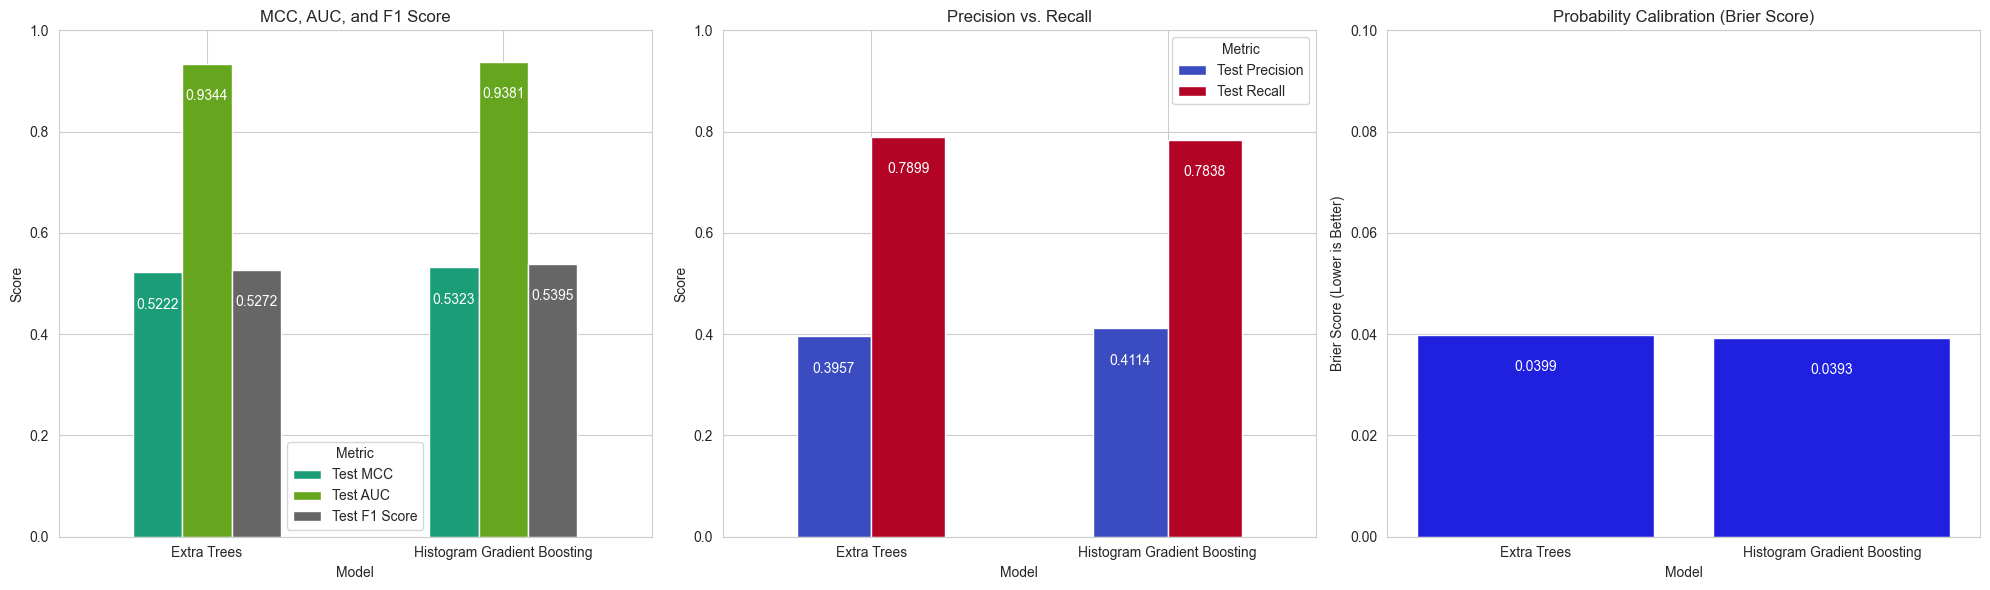

In [27]:
# **Adding Numeric Annotations Inside Bars for All Plots**
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# **Prepare Data for Visualization**
results_data = {
    "Model": ["Extra Trees", "Histogram Gradient Boosting"],
    "Test MCC": [0.5222, 0.5323],
    "Test AUC": [0.9344, 0.9381],
    "Test F1 Score": [0.5272, 0.5395],
    "Test Precision": [0.3957, 0.4114],
    "Test Recall": [0.7899, 0.7838],
    "Test Brier Score": [0.0399, 0.0393]
}

df_results = pd.DataFrame(results_data)

# **Set up a 1-row, 3-column plot layout**
fig, axes = plt.subplots(1, 3, figsize=(20, 6))  # Adjusted for a wider layout
sns.set_style("whitegrid")
colors = ["blue", "red"]  # Consistent color for both models

# **Plot 1: MCC, AUC, and F1 Score Comparison**
ax = axes[0]
df_results.set_index("Model")[["Test MCC", "Test AUC", "Test F1 Score"]].plot(kind="bar", ax=ax, colormap="Dark2")
ax.set_ylim(0, 1)
ax.set_ylabel("Score")
ax.set_title("MCC, AUC, and F1 Score")
ax.legend(title="Metric")
ax.set_xticklabels(df_results["Model"], rotation=0)

# Add numbers inside bars
for p in ax.patches:
    ax.annotate(f"{p.get_height():.4f}", (p.get_x() + p.get_width() / 2., p.get_height() - 0.05), 
                ha="center", va="top", fontsize=10, color="white")

# **Plot 2: Precision vs. Recall per Model**
ax = axes[1]
df_results.set_index("Model")[["Test Precision", "Test Recall"]].plot(kind="bar", ax=ax, colormap="coolwarm")
ax.set_ylim(0, 1)
ax.set_ylabel("Score")
ax.set_title("Precision vs. Recall")
ax.legend(title="Metric")
ax.set_xticklabels(df_results["Model"], rotation=0)

# Add numbers inside bars
for p in ax.patches:
    ax.annotate(f"{p.get_height():.4f}", (p.get_x() + p.get_width() / 2., p.get_height() - 0.05), 
                ha="center", va="top", fontsize=10, color="white")

# **Plot 3: Brier Score Comparison**
ax = axes[2]
sns.barplot(x="Model", y="Test Brier Score", data=df_results, ax=ax, color="blue")
ax.set_ylim(0, 0.1)  # Adjusted for better visibility
ax.set_ylabel("Brier Score (Lower is Better)")
ax.set_title("Probability Calibration (Brier Score)")
ax.set_xticklabels(df_results["Model"], rotation=0)

# Add numbers inside bars
for p in ax.patches:
    ax.annotate(f"{p.get_height():.4f}", (p.get_x() + p.get_width() / 2., p.get_height() - 0.005), 
                ha="center", va="top", fontsize=10, color="white")

# **Finalize Layout**
plt.tight_layout()
plt.show()

### Linear Regression and Feature Analysis (p-values)

In [6]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy import stats

# Load dataset
file_path = "/Users/faith/Desktop/BIO1018-Chromatin-Accessibility-ML/data/final_feature_matrix.csv"
columns = ["chromosome", "Start", "End", "chromatin_state", "H3K4me1", "H3K4me3", "H3K27ac", 
           "H3K27me3", "H3K9me3", "H3K36me3", "ESR1_signal", "FOXA1_signal", "GATA3_signal"]

df = pd.read_csv(file_path, sep=",", names=columns)

# Ensure chromatin_state is numeric
df["chromatin_state"] = pd.to_numeric(df["chromatin_state"], errors="coerce")
df = df.dropna(subset=["chromatin_state"])
df["chromatin_state"] = df["chromatin_state"].astype(int)

# Select chromosome for leave-out
leave_out_chromosome = "chr1"  # Change this manually if needed

# Split data: Leave out the chosen chromosome for testing
train_df = df[df["chromosome"] != leave_out_chromosome]
test_df = df[df["chromosome"] == leave_out_chromosome]

# Extract Features & Target
feature_columns = ["H3K4me1", "H3K4me3", "H3K27ac", "H3K27me3", "H3K9me3", "H3K36me3",
                   "ESR1_signal", "FOXA1_signal", "GATA3_signal"]

X_train = train_df[feature_columns]
y_train = train_df["chromatin_state"]

X_test = test_df[feature_columns]
y_test = test_df["chromatin_state"]

# Apply MinMaxScaler to ALL features together (histones + TFs)
scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Add constant (intercept) for regression
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit Ordinary Least Squares (OLS) Regression Model
ols_model = sm.OLS(y_train, X_train).fit()

# Get model summary
print("\nLinear Regression Model Summary:")
print(ols_model.summary())

# Extract feature importance: Coefficients & p-values
feature_importance = pd.DataFrame({
    "Feature": ["Intercept"] + feature_columns,
    "Coefficient": ols_model.params.values,
    "P-Value": ols_model.pvalues.values
})

# Sort by p-value (smallest p-values are most significant)
feature_importance = feature_importance.sort_values(by="P-Value")

print("\nFeature Importance (Sorted by P-Value):")
print(feature_importance)

# Predict on test set
y_test_pred = ols_model.predict(X_test)

# Calculate R-squared on test set
test_r2 = 1 - np.sum((y_test - y_test_pred) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2)
print(f"\nTest R-squared: {test_r2:.4f}")

/var/folders/09/0r9l07110lg5nj9ndgsx9kl80000gn/T/ipykernel_1232/1826217190.py:13: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=",", names=columns)



Linear Regression Model Summary:
                            OLS Regression Results                            
Dep. Variable:        chromatin_state   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                 1.326e+05
Date:                Sat, 15 Mar 2025   Prob (F-statistic):               0.00
Time:                        17:23:07   Log-Likelihood:             7.4525e+05
No. Observations:             2580540   AIC:                        -1.490e+06
Df Residuals:                 2580530   BIC:                        -1.490e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0

### Plotting Linear Regression Model Results
- Positive coefficients (blue dots): Features that increase chromatin accessibility.
- Negative coefficients (red dots): Features that decrease chromatin accessibility.

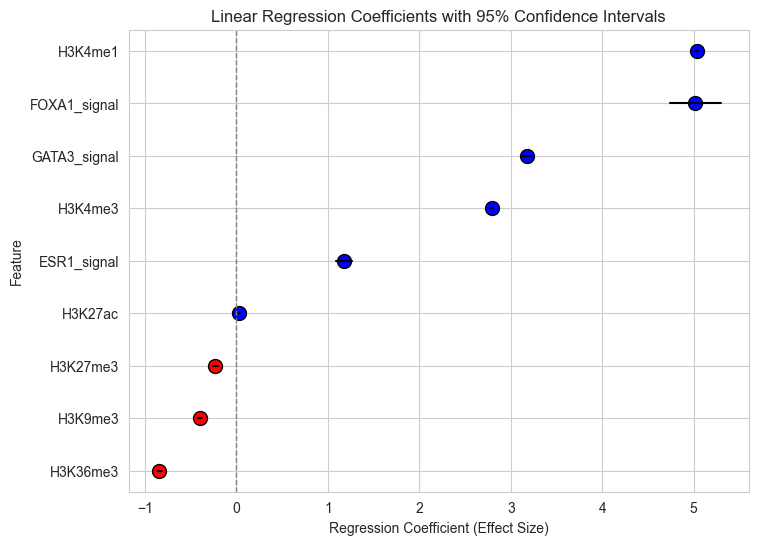

In [9]:
# **Re-load necessary libraries**
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# **Prepare Data for Visualization**
coef_data = {
    "Feature": ["H3K4me1", "H3K4me3", "H3K27ac", "H3K27me3", "H3K9me3", "H3K36me3", "ESR1_signal", "FOXA1_signal", "GATA3_signal"],
    "Coefficient": [5.0307, 2.7922, 0.0237, -0.2310, -0.4004, -0.8415, 1.1788, 5.0186, 3.1792],
    "Lower CI": [5.015, 2.782, 0.011, -0.260, -0.424, -0.869, 1.092, 4.743, 3.135],
    "Upper CI": [5.047, 2.803, 0.036, -0.202, -0.377, -0.814, 1.265, 5.294, 3.224]
}

df_coef = pd.DataFrame(coef_data)
df_coef = df_coef.sort_values(by="Coefficient", ascending=True)  # Sort for clear visualization

# **Plot: Coefficient Plot with 95% Confidence Intervals**
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")

# Scatter plot for coefficients
for i, coef in enumerate(df_coef["Coefficient"]):
    color = "blue" if coef > 0 else "red"
    plt.scatter(coef, i, color=color, s=100, edgecolor="black", linewidth=1)

# Add error bars for 95% CI
for i in range(df_coef.shape[0]):
    plt.plot([df_coef["Lower CI"].iloc[i], df_coef["Upper CI"].iloc[i]], 
             [i, i], color="black", linewidth=1.5)

plt.axvline(x=0, linestyle="dashed", color="gray", linewidth=1)  # Reference line at 0
plt.yticks(range(len(df_coef)), df_coef["Feature"])
plt.xlabel("Regression Coefficient (Effect Size)")
plt.ylabel("Feature")
plt.title("Linear Regression Coefficients with 95% Confidence Intervals")
plt.show()

### Redundancy Between Histone Modifications and Transcription Factor Signals in Chromatin Accessibility Prediction
Correlation Matrix to Analyse Co-Linearity

/var/folders/09/0r9l07110lg5nj9ndgsx9kl80000gn/T/ipykernel_1232/3568661640.py:12: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=",", names=columns)


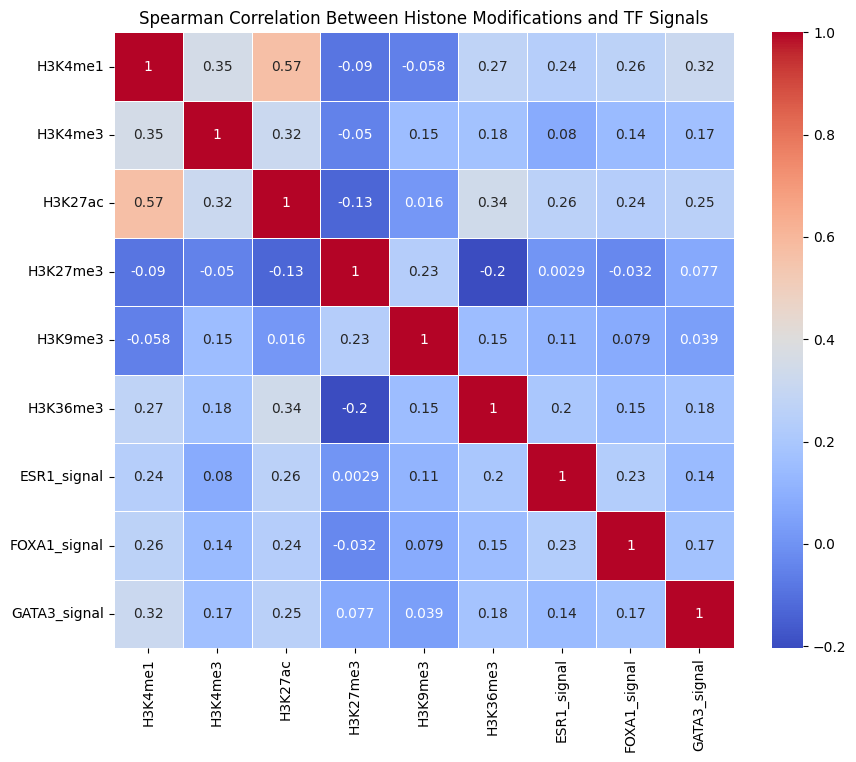

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Load dataset
file_path = "/Users/faith/Desktop/BIO1018-Chromatin-Accessibility-ML/data/final_feature_matrix.csv"
columns = ["chromosome", "Start", "End", "chromatin_state", "H3K4me1", "H3K4me3", "H3K27ac", 
           "H3K27me3", "H3K9me3", "H3K36me3", "ESR1_signal", "FOXA1_signal", "GATA3_signal"]

df = pd.read_csv(file_path, sep=",", names=columns)

# Extract relevant features for correlation analysis
histone_marks = ["H3K4me1", "H3K4me3", "H3K27ac", "H3K27me3", "H3K9me3", "H3K36me3"]
tf_signals = ["ESR1_signal", "FOXA1_signal", "GATA3_signal"]
all_features = histone_marks + tf_signals  # Combine feature lists

# **Convert Features to Numeric (Fix String Issue)**
for column in all_features:
    df[column] = pd.to_numeric(df[column], errors='coerce')  # Convert, setting errors to NaN

# **Drop NaN Rows to Ensure Clean Data**
df = df.dropna(subset=all_features)

# **Compute Spearman Correlation**
correlation_matrix = df[all_features].corr(method='spearman')

# **Plot Heatmap of Correlation Matrix**
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Spearman Correlation Between Histone Modifications and TF Signals")
plt.show()

### Final Model Tests and Grid Search for Hyperparamter Tuning


Leaving out chr1 for testing...

Testing: Class Weights={0: 1, 1: 16.00484664899659}, Threshold=0.3, Downsampling=5x
7018/7018 ━━━━━━━━━━━━━━━━━━━━ 5s 649us/step
Results: AUC=0.9228, AUPRC=0.6418, Precision=0.1733, Recall=0.9149, MCC=0.3265

Testing: Class Weights={0: 1, 1: 16.00484664899659}, Threshold=0.3, Downsampling=10x
7018/7018 ━━━━━━━━━━━━━━━━━━━━ 5s 756us/step
Results: AUC=0.9258, AUPRC=0.6510, Precision=0.1912, Recall=0.9062, MCC=0.3499

Testing: Class Weights={0: 1, 1: 16.00484664899659}, Threshold=0.3, Downsampling=15x
7018/7018 ━━━━━━━━━━━━━━━━━━━━ 5s 678us/step
Results: AUC=0.9251, AUPRC=0.6520, Precision=0.2176, Recall=0.8893, MCC=0.3796

Testing: Class Weights={0: 1, 1: 16.00484664899659}, Threshold=0.5, Downsampling=5x
7018/7018 ━━━━━━━━━━━━━━━━━━━━ 5s 672us/step
Results: AUC=0.9236, AUPRC=0.6440, Precision=0.2155, Recall=0.8885, MCC=0.3767

Testing: Class Weights={0: 1, 1: 16.00484664899659}, Threshold=0.5, Downsampling=10x
7018/7018 ━━━━━━━━━━━━━━━━━━━━ 6s 811us/ste

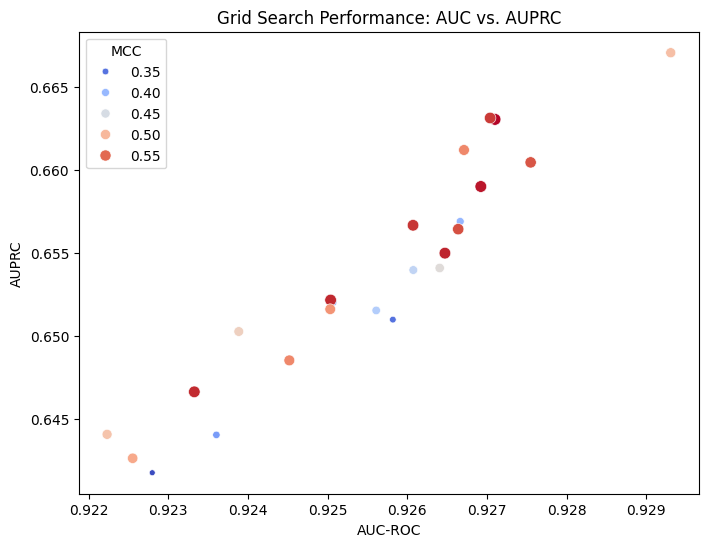

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, precision_score, recall_score, matthews_corrcoef, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras.backend as K
from itertools import product  # For hyperparameter combinations

# **Define MCC for TensorFlow**
def matthews_correlation(y_true, y_pred):
    """ Compute MCC in TensorFlow for real-time model evaluation. """
    y_true = K.cast(y_true, "float32")
    y_pred = K.round(K.cast(y_pred, "float32"))

    tp = K.sum(y_true * y_pred)
    tn = K.sum((1 - y_true) * (1 - y_pred))
    fp = K.sum((1 - y_true) * y_pred)
    fn = K.sum(y_true * (1 - y_pred))

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn) + K.epsilon())

    return numerator / (denominator + K.epsilon())

# **Load dataset**
file_path = "/Users/faith/Desktop/BIO1018-Chromatin-Accessibility-ML/data/final_feature_matrix.csv"
df = pd.read_csv(file_path, sep=",", header=0)

# Ensure chromatin_state is numeric
df["chromatin_state"] = pd.to_numeric(df["chromatin_state"], errors="coerce")
df = df.dropna(subset=["chromatin_state"])
df["chromatin_state"] = df["chromatin_state"].astype(int)

# **Encode chromosomes numerically for LOCO splits**
df["chromosome"] = df["chromosome"].astype("category")
chromosome_mapping = dict(enumerate(df["chromosome"].cat.categories))  
df["chromosome"] = df["chromosome"].cat.codes  

# **Select the chromosome to leave out**
leave_out_chromosome = "chr1"

# Map chromosome name back to its numeric code
chrom_num = [num for num, name in chromosome_mapping.items() if name == leave_out_chromosome][0]

print(f"\nLeaving out {leave_out_chromosome} for testing...")

# **Split train/test based on the chosen chromosome**
train_df = df[df["chromosome"] != chrom_num]
test_df = df[df["chromosome"] == chrom_num]

# **Check class distribution in the test set**
test_class_counts = test_df["chromatin_state"].value_counts(normalize=True)
test_ratio = test_class_counts[1] / test_class_counts[0]  

# **Define hyperparameter grid**
class_weight_options = [{0: 1, 1: 1/test_ratio}, {0: 1, 1: 2}]
threshold_options = [0.3, 0.5, 0.7, 0.9]
downsampling_ratios = [5, 10, 15]

# **Feature Columns**
feature_columns = ["H3K4me1", "H3K4me3", "H3K27ac", "H3K27me3", "H3K9me3", "H3K36me3",
                   "ESR1_signal", "FOXA1_signal", "GATA3_signal"]

# **Hyperparameter Grid Search Loop**
results = []  # Store results

for class_weights, threshold, downsample_ratio in product(class_weight_options, threshold_options, downsampling_ratios):
    print(f"\nTesting: Class Weights={class_weights}, Threshold={threshold}, Downsampling={downsample_ratio}x")

    # **Downsample Majority Class**
    majority_class = train_df[train_df["chromatin_state"] == 0]
    minority_class = train_df[train_df["chromatin_state"] == 1]

    n_majority = min(len(majority_class), downsample_ratio * len(minority_class))
    majority_downsampled = majority_class.sample(n=n_majority, random_state=42)

    train_df_balanced = pd.concat([majority_downsampled, minority_class]).sample(frac=1, random_state=42)

    # **Extract Features & Targets**
    X_train = train_df_balanced[feature_columns]
    y_train = train_df_balanced["chromatin_state"]
    X_test = test_df[feature_columns]
    y_test = test_df["chromatin_state"]

    # **Normalize Features**
    scaler = MinMaxScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # **Define Neural Network Model**
    input_layer = Input(shape=(X_train.shape[1],), name="Feature_Input")
    dense = Dense(64, activation='relu')(input_layer)
    dense = Dropout(0.3)(dense)
    dense = Dense(32, activation='relu')(dense)
    dense = Dropout(0.3)(dense)
    output_layer = Dense(1, activation='sigmoid', name="Output")(dense)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss="binary_crossentropy", 
                  metrics=[tf.keras.metrics.Precision(), 
                           tf.keras.metrics.Recall(), 
                           matthews_correlation])

    # **Train Model**
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(
        X_train, y_train, 
        epochs=50, batch_size=32,  
        validation_split=0.2, 
        class_weight=class_weights,
        callbacks=[early_stopping], verbose=0
    )

    # **Evaluate Model**
    y_test_probs = model.predict(X_test, batch_size=32)
    y_test_pred = (y_test_probs > threshold).astype(int).reshape(-1)

    # **Compute Metrics**
    test_auc = roc_auc_score(y_test, y_test_probs) if len(np.unique(y_test)) > 1 else np.nan
    test_precision = precision_score(y_test, y_test_pred, zero_division=0)
    test_recall = recall_score(y_test, y_test_pred, zero_division=0)
    test_mcc = matthews_corrcoef(y_test, y_test_pred) if len(np.unique(y_test_pred)) > 1 else 0
    test_auprc = average_precision_score(y_test, y_test_probs) if len(np.unique(y_test)) > 1 else np.nan

    # **Print Results Immediately**
    print(f"Results: AUC={test_auc:.4f}, AUPRC={test_auprc:.4f}, Precision={test_precision:.4f}, Recall={test_recall:.4f}, MCC={test_mcc:.4f}")

    # **Store results**
    results.append({
        "Class Weights": class_weights, "Threshold": threshold, "Downsampling": downsample_ratio,
        "AUC": test_auc, "AUPRC": test_auprc, "Precision": test_precision, "Recall": test_recall, "MCC": test_mcc
    })

# **Convert results into a DataFrame**
results_df = pd.DataFrame(results)

# **Display Final Results**
print("\nFinal Grid Search Results:")
print(results_df.sort_values(by=["MCC"], ascending=False).to_string(index=False))

# **Plot AUC vs. AUPRC**
plt.figure(figsize=(8, 6))
sns.scatterplot(data=results_df, x="AUC", y="AUPRC", hue="MCC", size="MCC", palette="coolwarm", legend=True)
plt.xlabel("AUC-ROC")
plt.ylabel("AUPRC")
plt.title("Grid Search Performance: AUC vs. AUPRC")
plt.show()

### Final LOCO-CV Model

2025-03-15 17:27:54.188440: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.



Leaving out chr1 for testing...

Test Set Class Distribution (Actual Counts):
chromatin_state
0    211344
1     13205
Name: count, dtype: int64
Epoch 1/50
26123/26123 ━━━━━━━━━━━━━━━━━━━━ 47s 2ms/step - loss: 0.4021 - matthews_correlation: 0.6138 - precision: 0.7277 - recall: 0.6673 - val_loss: 0.2713 - val_matthews_correlation: 0.6384 - val_precision: 0.6480 - val_recall: 0.7934
Epoch 2/50
26123/26123 ━━━━━━━━━━━━━━━━━━━━ 47s 2ms/step - loss: 0.3511 - matthews_correlation: 0.6475 - precision: 0.6982 - recall: 0.7442 - val_loss: 0.2358 - val_matthews_correlation: 0.6496 - val_precision: 0.6794 - val_recall: 0.7730
Epoch 3/50
26123/26123 ━━━━━━━━━━━━━━━━━━━━ 46s 2ms/step - loss: 0.3448 - matthews_correlation: 0.6534 - precision: 0.7075 - recall: 0.7434 - val_loss: 0.2296 - val_matthews_correlation: 0.6566 - val_precision: 0.7142 - val_recall: 0.7440
Epoch 4/50
26123/26123 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - loss: 0.3449 - matthews_correlation: 0.6511 - precision: 0.7045 - recall: 0.744

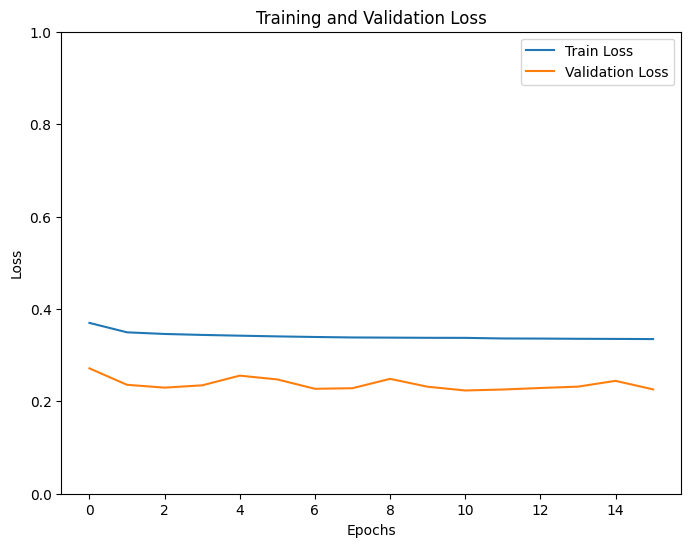

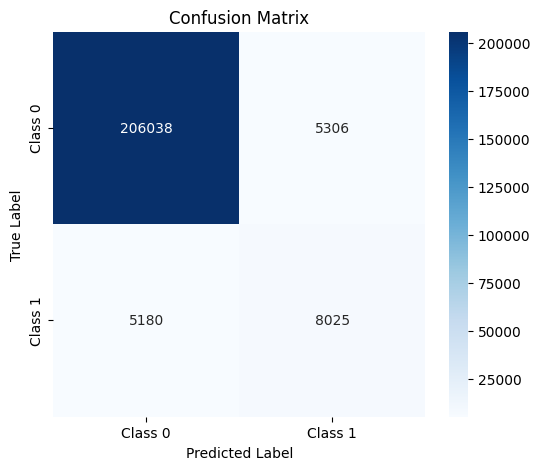

In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, precision_score, recall_score, matthews_corrcoef, average_precision_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras.backend as K

# **Define MCC Metric for TensorFlow**
def matthews_correlation(y_true, y_pred):
    """ Compute MCC in TensorFlow for model evaluation. """
    y_true = K.cast(y_true, "float32")
    y_pred = K.round(K.cast(y_pred, "float32"))

    tp = K.sum(y_true * y_pred)
    tn = K.sum((1 - y_true) * (1 - y_pred))
    fp = K.sum((1 - y_true) * y_pred)
    fn = K.sum(y_true * (1 - y_pred))

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn) + K.epsilon())

    return numerator / (denominator + K.epsilon())

# **Load dataset**
file_path = "/Users/faith/Desktop/BIO1018-Chromatin-Accessibility-ML/data/final_feature_matrix.csv"
df = pd.read_csv(file_path, sep=",", header=0)

# Ensure chromatin_state is numeric
df["chromatin_state"] = pd.to_numeric(df["chromatin_state"], errors="coerce")
df = df.dropna(subset=["chromatin_state"])
df["chromatin_state"] = df["chromatin_state"].astype(int)

# **Encode chromosomes numerically for LOCO splits**
df["chromosome"] = df["chromosome"].astype("category")
chromosome_mapping = dict(enumerate(df["chromosome"].cat.categories))  
df["chromosome"] = df["chromosome"].cat.codes  

# **Select the chromosome to leave out**
leave_out_chromosome = "chr1"

# Map chromosome name back to its numeric code
chrom_num = [num for num, name in chromosome_mapping.items() if name == leave_out_chromosome][0]

print(f"\nLeaving out {leave_out_chromosome} for testing...")

# **Split train/test based on the chosen chromosome**
train_df = df[df["chromosome"] != chrom_num]
test_df = df[df["chromosome"] == chrom_num]

# **Check class distribution in test set**
print("\nTest Set Class Distribution (Actual Counts):")
print(test_df["chromatin_state"].value_counts())

# **Downsample the majority class in the training set to 5× the minority class**
majority_class = train_df[train_df["chromatin_state"] == 0]
minority_class = train_df[train_df["chromatin_state"] == 1]

# Define new majority class size (5× the minority count)
if len(minority_class) > 0:
    n_majority = min(len(majority_class), 5 * len(minority_class))
else:
    n_majority = 10  

# Downsample the majority class
majority_downsampled = majority_class.sample(n=n_majority, random_state=42)

# Create balanced training set
train_df_balanced = pd.concat([majority_downsampled, minority_class]).sample(frac=1, random_state=42)

# **Feature Columns**
feature_columns = ["H3K4me1", "H3K4me3", "H3K27ac", "H3K27me3", "H3K9me3", "H3K36me3",
                   "ESR1_signal", "FOXA1_signal", "GATA3_signal"]

# **Extract Features & Targets**
X_train = train_df_balanced[feature_columns]
y_train = train_df_balanced["chromatin_state"]
X_test = test_df[feature_columns]
y_test = test_df["chromatin_state"]

# **Normalize Features**
scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# **Define Neural Network Model**
input_layer = Input(shape=(X_train.shape[1],), name="Feature_Input")
dense = Dense(64, activation='relu')(input_layer)
dense = Dropout(0.3)(dense)
dense = Dense(32, activation='relu')(dense)
dense = Dropout(0.3)(dense)
output_layer = Dense(1, activation='sigmoid', name="Output")(dense)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss="binary_crossentropy", 
              metrics=[tf.keras.metrics.Precision(), 
                       tf.keras.metrics.Recall(), 
                       matthews_correlation])

class_weights = {0:1, 1:2}

# **Train Model**
batch_size = 24
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train, 
    epochs=50, batch_size=batch_size,  
    validation_split=0.2, 
    class_weight=class_weights,
    callbacks=[early_stopping], verbose=1
)

# **Model Evaluation**
y_test_probs = model.predict(X_test, batch_size=batch_size)
y_test_pred = (y_test_probs > 0.7).astype(int).reshape(-1)  

# **Compute Metrics**
test_auc = roc_auc_score(y_test, y_test_probs) if len(np.unique(y_test)) > 1 else np.nan
test_precision = precision_score(y_test, y_test_pred, zero_division=0)
test_recall = recall_score(y_test, y_test_pred, zero_division=0)
test_mcc = matthews_corrcoef(y_test, y_test_pred) if len(np.unique(y_test_pred)) > 1 else 0
test_f1 = f1_score(y_test, y_test_pred, zero_division=0)
test_auprc = average_precision_score(y_test, y_test_probs) if len(np.unique(y_test)) > 1 else np.nan

# **False Positive Rate Calculation**
tn = np.sum(y_test == 0)
test_fpr = np.sum((y_test_pred == 1) & (y_test == 0)) / tn if tn > 0 else 0

# **Print Evaluation Metrics**
print(f"\nChromosome {leave_out_chromosome} Test Set Performance")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test AUPRC: {test_auprc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test MCC: {test_mcc:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test FPR (1 - Specificity): {test_fpr:.4f}")

# **Plot Loss Curves**
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.ylim(0, 1)  # Ensuring Y-axis is between 0 and 1
plt.legend()
plt.show()

# **Confusion Matrix**
conf_matrix = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

###  Model Calibration Evaluation with Brier Score and Calibration Curve

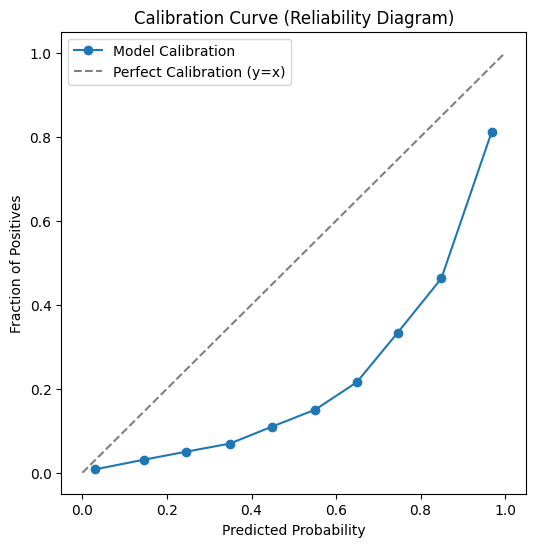

Expected Calibration Error (ECE): 0.0842


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# **Compute Calibration Curve**
prob_true, prob_pred = calibration_curve(y_test, y_test_probs, n_bins=10, strategy='uniform')

# **Plot Calibration Curve**
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label="Model Calibration")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfect Calibration (y=x)")
plt.xlabel("Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve (Reliability Diagram)")
plt.legend()
plt.show()

# **Compute Expected Calibration Error (ECE)**
ece = np.sum(np.abs(prob_true - prob_pred) * np.histogram(y_test_probs, bins=10, range=(0, 1))[0] / len(y_test))
print(f"Expected Calibration Error (ECE): {ece:.4f}")

### Comparing TF-Only vs. Histone-Only Models for Chromatin Accessibility Prediction
This experiment trains two separate neural network models:

TF-Only Model: Uses only transcription factor (TF) signals as input features.
Histone-Only Model: Uses only histone modification signals as input features.

By evaluating their performance, we can determine if TF signals provide redundant information or if histone modifications alone are sufficient for predicting chromatin accessibility.


Training TF-Only Model...
Epoch 1/50
26123/26123 ━━━━━━━━━━━━━━━━━━━━ 64s 2ms/step - loss: 0.6471 - precision_2: 0.6821 - recall_2: 0.1590 - val_loss: 0.4182 - val_precision_2: 0.6133 - val_recall_2: 0.2738
Epoch 2/50
26123/26123 ━━━━━━━━━━━━━━━━━━━━ 52s 2ms/step - loss: 0.6047 - precision_2: 0.5759 - recall_2: 0.2934 - val_loss: 0.4276 - val_precision_2: 0.5982 - val_recall_2: 0.3067
Epoch 3/50
26123/26123 ━━━━━━━━━━━━━━━━━━━━ 54s 2ms/step - loss: 0.5982 - precision_2: 0.5760 - recall_2: 0.3168 - val_loss: 0.4337 - val_precision_2: 0.5530 - val_recall_2: 0.3585
Epoch 4/50
26123/26123 ━━━━━━━━━━━━━━━━━━━━ 52s 2ms/step - loss: 0.5905 - precision_2: 0.5750 - recall_2: 0.3386 - val_loss: 0.3729 - val_precision_2: 0.6652 - val_recall_2: 0.2964
Epoch 5/50
26123/26123 ━━━━━━━━━━━━━━━━━━━━ 53s 2ms/step - loss: 0.5841 - precision_2: 0.5764 - recall_2: 0.3582 - val_loss: 0.3784 - val_precision_2: 0.6413 - val_recall_2: 0.3390
Epoch 6/50
26123/26123 ━━━━━━━━━━━━━━━━━━━━ 55s 2ms/step - loss: 0.5

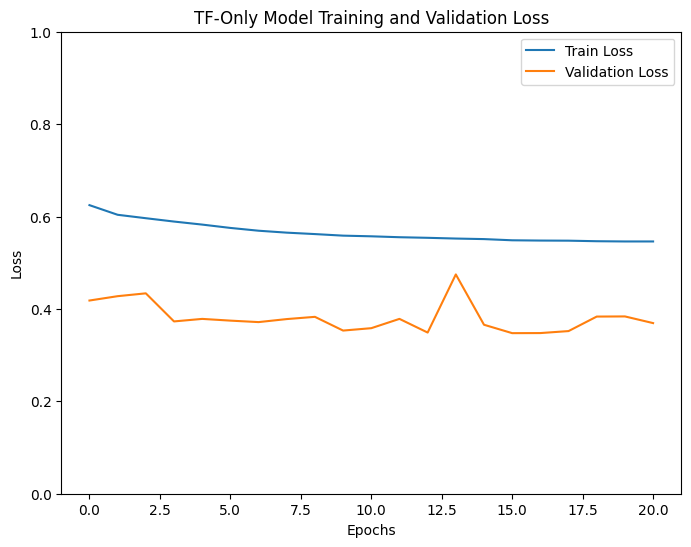


Training Histone-Only Model...
Epoch 1/50
26123/26123 ━━━━━━━━━━━━━━━━━━━━ 60s 2ms/step - loss: 0.4028 - precision_3: 0.7203 - recall_3: 0.6728 - val_loss: 0.2377 - val_precision_3: 0.6979 - val_recall_3: 0.7419
Epoch 2/50
26123/26123 ━━━━━━━━━━━━━━━━━━━━ 63s 2ms/step - loss: 0.3536 - precision_3: 0.6940 - recall_3: 0.7473 - val_loss: 0.2401 - val_precision_3: 0.6967 - val_recall_3: 0.7522
Epoch 3/50
26123/26123 ━━━━━━━━━━━━━━━━━━━━ 67s 3ms/step - loss: 0.3513 - precision_3: 0.7059 - recall_3: 0.7412 - val_loss: 0.2408 - val_precision_3: 0.6990 - val_recall_3: 0.7532
Epoch 4/50
26123/26123 ━━━━━━━━━━━━━━━━━━━━ 69s 3ms/step - loss: 0.3490 - precision_3: 0.7109 - recall_3: 0.7394 - val_loss: 0.2325 - val_precision_3: 0.7419 - val_recall_3: 0.7101
Epoch 5/50
26123/26123 ━━━━━━━━━━━━━━━━━━━━ 61s 2ms/step - loss: 0.3469 - precision_3: 0.7071 - recall_3: 0.7407 - val_loss: 0.2386 - val_precision_3: 0.6827 - val_recall_3: 0.7680
Epoch 6/50
26123/26123 ━━━━━━━━━━━━━━━━━━━━ 54s 2ms/step - loss

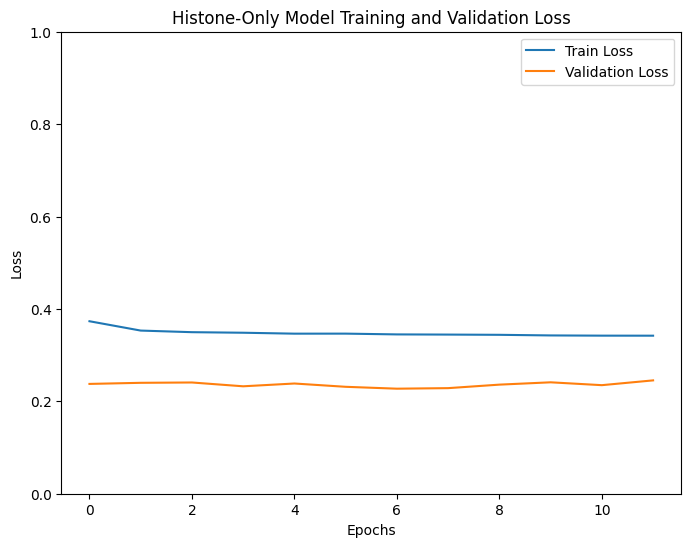


Performance Comparison:
          Model  Test AUC  Test Brier Score  Test Precision  Test Recall  \
0       TF-Only  0.812548          0.061797        0.548160     0.224536   
1  Histone-Only  0.924183          0.052664        0.604092     0.597047   

   Test MCC  Test F1 Score  
0  0.326789       0.318577  
1  0.575757       0.600548  


In [18]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, precision_score, recall_score, matthews_corrcoef, f1_score, brier_score_loss
import matplotlib.pyplot as plt

# **Load dataset**
file_path = "/Users/faith/Desktop/BIO1018-Chromatin-Accessibility-ML/data/final_feature_matrix.csv"
df = pd.read_csv(file_path, sep=",", header=0)

# Ensure chromatin_state is numeric
df["chromatin_state"] = pd.to_numeric(df["chromatin_state"], errors="coerce")
df = df.dropna(subset=["chromatin_state"])
df["chromatin_state"] = df["chromatin_state"].astype(int)

# **Encode chromosomes numerically for LOCO splits**
df["chromosome"] = df["chromosome"].astype("category")
chromosome_mapping = dict(enumerate(df["chromosome"].cat.categories))  
df["chromosome"] = df["chromosome"].cat.codes  

# **Select the chromosome to leave out**
leave_out_chromosome = "chr1"
chrom_num = [num for num, name in chromosome_mapping.items() if name == leave_out_chromosome][0]

# **Split train/test based on the chosen chromosome**
train_df = df[df["chromosome"] != chrom_num]
test_df = df[df["chromosome"] == chrom_num]

# **Balance Training Set**
majority_class = train_df[train_df["chromatin_state"] == 0]
minority_class = train_df[train_df["chromatin_state"] == 1]

if len(minority_class) > 0:
    n_majority = min(len(majority_class), 5 * len(minority_class))
else:
    n_majority = 10  

majority_downsampled = majority_class.sample(n=n_majority, random_state=42)
train_df_balanced = pd.concat([majority_downsampled, minority_class]).sample(frac=1, random_state=42)

# **Define Feature Groups**
histone_marks = ["H3K4me1", "H3K4me3", "H3K27ac", "H3K27me3", "H3K9me3", "H3K36me3"]
tf_signals = ["ESR1_signal", "FOXA1_signal", "GATA3_signal"]

# **Train Two Models: One for TFs, One for Histones**
feature_sets = {"TF-Only": tf_signals, "Histone-Only": histone_marks}
results = []

for model_name, feature_columns in feature_sets.items():
    print(f"\nTraining {model_name} Model...")

    # **Extract Features & Targets**
    X_train = train_df_balanced[feature_columns]
    y_train = train_df_balanced["chromatin_state"]
    X_test = test_df[feature_columns]
    y_test = test_df["chromatin_state"]

    # **Normalize Features**
    scaler = MinMaxScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # **Define Neural Network Model**
    input_layer = Input(shape=(X_train.shape[1],), name="Feature_Input")
    dense = Dense(64, activation='relu')(input_layer)
    dense = Dropout(0.3)(dense)
    dense = Dense(32, activation='relu')(dense)
    dense = Dropout(0.3)(dense)
    output_layer = Dense(1, activation='sigmoid', name="Output")(dense)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss="binary_crossentropy", 
                  metrics=[tf.keras.metrics.Precision(), 
                           tf.keras.metrics.Recall()])

    
    class_weights = {0:1, 1:2}

    # **Train Model**
    batch_size = 24
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train, y_train, 
        epochs=50, batch_size=batch_size,  
        validation_split=0.2, 
        class_weight=class_weights,
        callbacks=[early_stopping], verbose=1
    )

    # **Model Evaluation**
    y_test_probs = model.predict(X_test, batch_size=batch_size)
    y_test_pred = (y_test_probs > 0.7).astype(int).reshape(-1)

    # **Compute Metrics**
    test_auc = roc_auc_score(y_test, y_test_probs) if len(np.unique(y_test)) > 1 else np.nan
    test_precision = precision_score(y_test, y_test_pred, zero_division=0)
    test_recall = recall_score(y_test, y_test_pred, zero_division=0)
    test_mcc = matthews_corrcoef(y_test, y_test_pred) if len(np.unique(y_test_pred)) > 1 else 0
    test_f1 = f1_score(y_test, y_test_pred, zero_division=0)
    test_brier = brier_score_loss(y_test, y_test_probs)

    # **Store Results**
    results.append({
        "Model": model_name,
        "Test AUC": test_auc,
        "Test Brier Score": test_brier,
        "Test Precision": test_precision,
        "Test Recall": test_recall,
        "Test MCC": test_mcc,
        "Test F1 Score": test_f1
    })

    # **Plot Loss Curves**
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Model Training and Validation Loss')
    plt.ylim(0, 1)
    plt.legend()
    plt.show()

# **Display Results**
results_df = pd.DataFrame(results)
print("\nPerformance Comparison:")
print(results_df)

### All Model Performances Compared

/var/folders/09/0r9l07110lg5nj9ndgsx9kl80000gn/T/ipykernel_973/4103515832.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_metrics, x="Model", y="AUC", ax=ax, palette=colors)
/var/folders/09/0r9l07110lg5nj9ndgsx9kl80000gn/T/ipykernel_973/4103515832.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_metrics, x="Model", y="MCC", ax=ax, palette=colors)
/var/folders/09/0r9l07110lg5nj9ndgsx9kl80000gn/T/ipykernel_973/4103515832.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_metrics, x="Model", y="F1 Score", ax=a

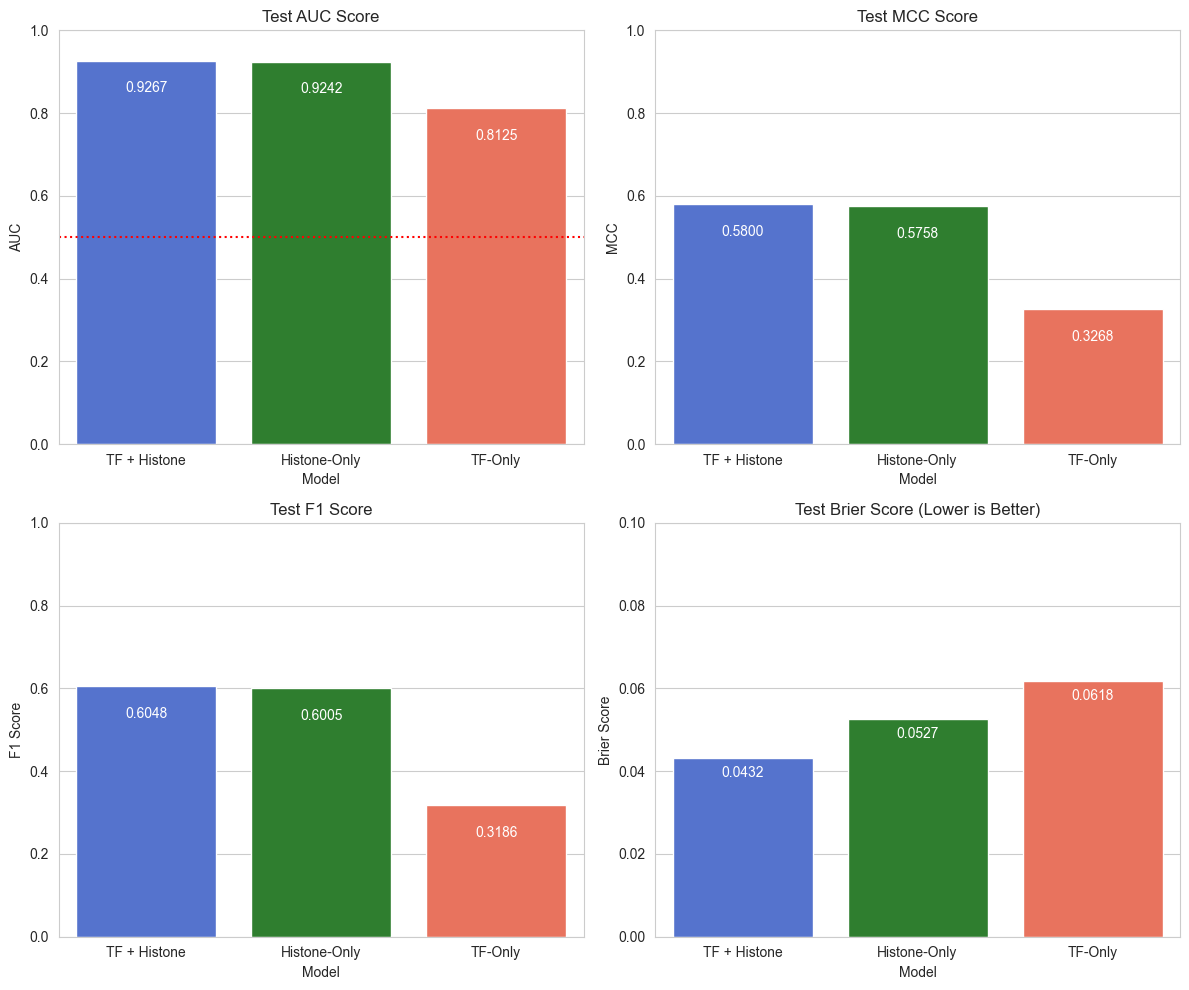

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# **Prepare Data for Visualization**
metrics_data = {
    "Model": ["TF + Histone", "Histone-Only", "TF-Only"],
    "AUC": [0.9267, 0.9242, 0.8125],
    "MCC": [0.5800, 0.5758, 0.3268],
    "F1 Score": [0.6048, 0.6005, 0.3186],
    "Brier Score": [0.0432, 0.0527, 0.0618]  # Lower is better
}

df_metrics = pd.DataFrame(metrics_data)

# **Plot Setup**
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
sns.set_style("whitegrid")
colors = ["royalblue", "forestgreen", "tomato"]  # TF + Histone (blue), Histone-Only (green), TF-Only (red)

# **Plot 1: AUC Score with Red Dotted Line at 0.5**
ax = axes[0, 0]
sns.barplot(data=df_metrics, x="Model", y="AUC", ax=ax, palette=colors)
ax.axhline(y=0.5, color="red", linestyle="dotted", linewidth=1.5)
for p in ax.patches:
    ax.annotate(f"{p.get_height():.4f}", (p.get_x() + p.get_width() / 2., p.get_height() - 0.05), 
                ha="center", va="top", fontsize=10, color="white")
ax.set_ylim(0, 1)
ax.set_title("Test AUC Score")
ax.set_ylabel("AUC")

# **Plot 2: MCC Score**
ax = axes[0, 1]
sns.barplot(data=df_metrics, x="Model", y="MCC", ax=ax, palette=colors)
for p in ax.patches:
    ax.annotate(f"{p.get_height():.4f}", (p.get_x() + p.get_width() / 2., p.get_height() - 0.05), 
                ha="center", va="top", fontsize=10, color="white")
ax.set_ylim(0, 1)
ax.set_title("Test MCC Score")
ax.set_ylabel("MCC")

# **Plot 3: F1 Score**
ax = axes[1, 0]
sns.barplot(data=df_metrics, x="Model", y="F1 Score", ax=ax, palette=colors)
for p in ax.patches:
    ax.annotate(f"{p.get_height():.4f}", (p.get_x() + p.get_width() / 2., p.get_height() - 0.05), 
                ha="center", va="top", fontsize=10, color="white")
ax.set_ylim(0, 1)
ax.set_title("Test F1 Score")
ax.set_ylabel("F1 Score")

# **Plot 4: Brier Score (Lower is Better, Adjusted Y-axis)**
ax = axes[1, 1]
sns.barplot(data=df_metrics, x="Model", y="Brier Score", ax=ax, palette=colors)
for p in ax.patches:
    ax.annotate(f"{p.get_height():.4f}", (p.get_x() + p.get_width() / 2., p.get_height() - 0.002), 
                ha="center", va="top", fontsize=10, color="white")
ax.set_ylim(0, 0.1)  # Adjusted Y-axis for Brier Score
ax.set_title("Test Brier Score (Lower is Better)")
ax.set_ylabel("Brier Score")

# **Finalize Layout**
plt.tight_layout()
plt.show()

### Permutation Importance Analysis for Feature Contribution
This code evaluates the **importance of histone modifications (HMs) and transcription factor (TF) signals** in predicting chromatin accessibility by using **permutation importance**.  

#### **What This Code Does:**
1. **Baseline Model Performance:**  
   - Computes **AUC (Area Under the Curve)** and **MCC (Matthews Correlation Coefficient)** with all features included.  

2. **Feature Importance via Permutation:**  
   - Iteratively **shuffles each feature** one at a time and measures the **drop in AUC and MCC**.  
   - Features that cause a **large drop in performance** when shuffled are considered **more important**.  

3. **Visualization:**  
   - **Bar Plot 1:** Shows the impact of removing each feature on **AUC**.  
   - **Bar Plot 2:** Shows the impact of removing each feature on **MCC**.  

#### **Why This Matters?**
- Helps identify **which histone marks or TFs are most predictive** of chromatin accessibility.  
- Can reveal **redundant features** if shuffling them does not impact model performance.  
- Provides **biological insights** into which epigenetic signals drive chromatin openness.  


Leaving out chr1 for testing...

Test Set Class Distribution (Actual Counts):
chromatin_state
0    211344
1     13205
Name: count, dtype: int64
Epoch 1/50
26123/26123 ━━━━━━━━━━━━━━━━━━━━ 50s 2ms/step - loss: 0.4022 - matthews_correlation: 0.6086 - precision_1: 0.7280 - recall_1: 0.6663 - val_loss: 0.2797 - val_matthews_correlation: 0.6414 - val_precision_1: 0.6609 - val_recall_1: 0.7813
Epoch 2/50
26123/26123 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step - loss: 0.3505 - matthews_correlation: 0.6456 - precision_1: 0.6945 - recall_1: 0.7500 - val_loss: 0.2433 - val_matthews_correlation: 0.6504 - val_precision_1: 0.6856 - val_recall_1: 0.7672
Epoch 3/50
26123/26123 ━━━━━━━━━━━━━━━━━━━━ 47s 2ms/step - loss: 0.3465 - matthews_correlation: 0.6492 - precision_1: 0.7024 - recall_1: 0.7444 - val_loss: 0.2302 - val_matthews_correlation: 0.6559 - val_precision_1: 0.7291 - val_recall_1: 0.7273
Epoch 4/50
26123/26123 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step - loss: 0.3438 - matthews_correlation: 0.6531 - precision

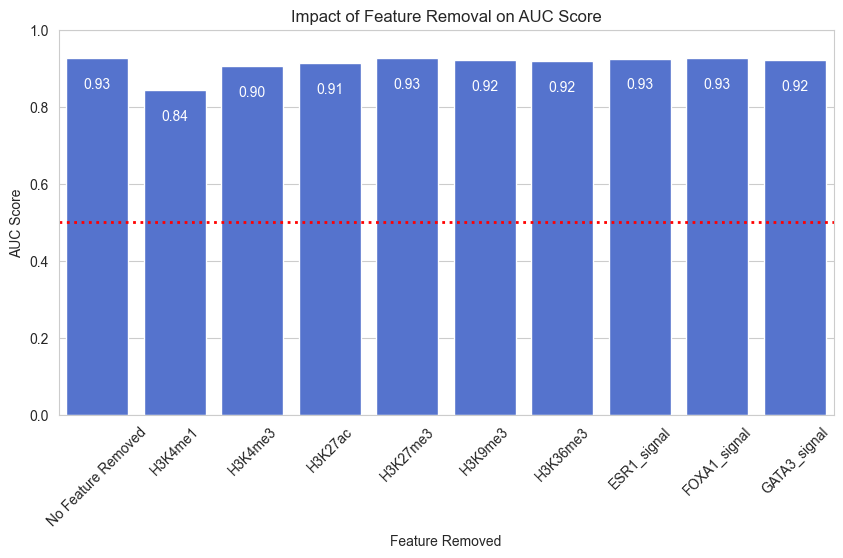

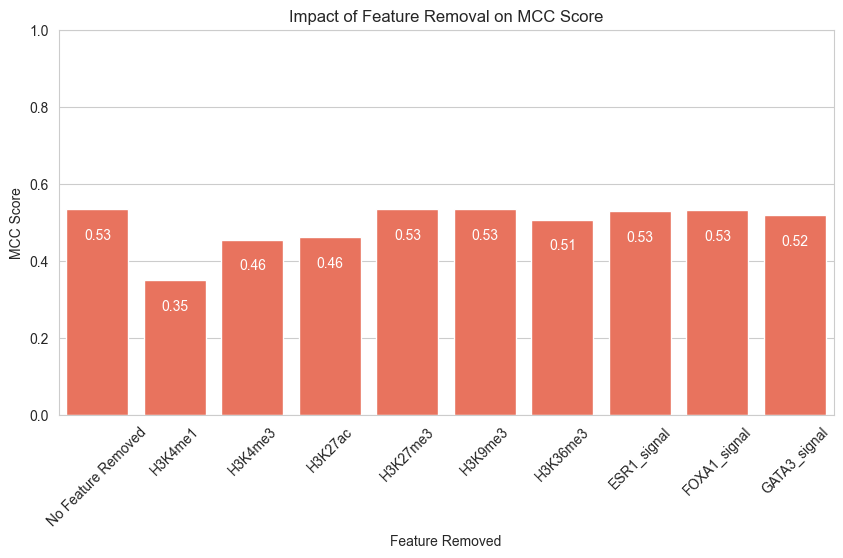

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, matthews_corrcoef

# **Define MCC Metric for TensorFlow**
import tensorflow.keras.backend as K
def matthews_correlation(y_true, y_pred):
    """ Compute MCC in TensorFlow for model evaluation. """
    y_true = K.cast(y_true, "float32")
    y_pred = K.round(K.cast(y_pred, "float32"))

    tp = K.sum(y_true * y_pred)
    tn = K.sum((1 - y_true) * (1 - y_pred))
    fp = K.sum((1 - y_true) * y_pred)
    fn = K.sum(y_true * (1 - y_pred))

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn) + K.epsilon())

    return numerator / (denominator + K.epsilon())

# **Step 1: Reload Dataset to Avoid Previous Code Conflicts**
file_path = "/Users/faith/Desktop/BIO1018-Chromatin-Accessibility-ML/data/final_feature_matrix.csv"
df = pd.read_csv(file_path, sep=",", header=0)

# Ensure chromatin_state is numeric
df["chromatin_state"] = pd.to_numeric(df["chromatin_state"], errors="coerce")
df = df.dropna(subset=["chromatin_state"])
df["chromatin_state"] = df["chromatin_state"].astype(int)

# **Encode chromosomes numerically for LOCO splits**
df["chromosome"] = df["chromosome"].astype("category")
chromosome_mapping = dict(enumerate(df["chromosome"].cat.categories))  
df["chromosome"] = df["chromosome"].cat.codes  

# **Select the chromosome to leave out**
leave_out_chromosome = "chr1"

# Map chromosome name back to its numeric code
chrom_num = [num for num, name in chromosome_mapping.items() if name == leave_out_chromosome][0]

print(f"\nLeaving out {leave_out_chromosome} for testing...")

# **Split train/test based on the chosen chromosome**
train_df = df[df["chromosome"] != chrom_num]
test_df = df[df["chromosome"] == chrom_num]

# **Check class distribution in test set**
print("\nTest Set Class Distribution (Actual Counts):")
print(test_df["chromatin_state"].value_counts())

# **Downsample the majority class in the training set to 5× the minority class**
majority_class = train_df[train_df["chromatin_state"] == 0]
minority_class = train_df[train_df["chromatin_state"] == 1]

# Define new majority class size (5× the minority count)
if len(minority_class) > 0:
    n_majority = min(len(majority_class), 5 * len(minority_class))
else:
    n_majority = 10  

# Downsample the majority class
majority_downsampled = majority_class.sample(n=n_majority, random_state=42)

# Create balanced training set
train_df_balanced = pd.concat([majority_downsampled, minority_class]).sample(frac=1, random_state=42)

# **Feature Columns**
feature_names = ["H3K4me1", "H3K4me3", "H3K27ac", "H3K27me3", "H3K9me3", "H3K36me3",
                 "ESR1_signal", "FOXA1_signal", "GATA3_signal"]

# **Extract Features & Targets**
X_train = train_df_balanced[feature_names]
y_train = train_df_balanced["chromatin_state"]
X_test = test_df[feature_names]
y_test = test_df["chromatin_state"]

# **Normalize Features (No Data Leakage)**
scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# **Step 2: Train a New Model with Final Hyperparameters**
input_layer = Input(shape=(X_train.shape[1],), name="Feature_Input")
dense = Dense(64, activation='relu')(input_layer)
dense = Dropout(0.3)(dense)
dense = Dense(32, activation='relu')(dense)
dense = Dropout(0.3)(dense)
output_layer = Dense(1, activation='sigmoid', name="Output")(dense)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss="binary_crossentropy", 
              metrics=[tf.keras.metrics.Precision(), 
                       tf.keras.metrics.Recall(), 
                       matthews_correlation])

class_weights = {0:1, 1:2}

# **Train Model**
batch_size = 24
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(
    X_train, y_train, 
    epochs=50, batch_size=batch_size,  
    validation_split=0.2, 
    class_weight=class_weights,
    callbacks=[early_stopping], verbose=1
)

# **Step 3: Compute Permutation Importance**
def permutation_importance(model, X_test, y_test, feature_names, metric=matthews_corrcoef, num_repeats=5):
    """ Compute feature importance by shuffling each feature and measuring the drop in AUC and MCC. """
    
    # Convert to DataFrame to maintain feature names
    X_test_df = pd.DataFrame(X_test, columns=feature_names)

    # Compute baseline scores with all features
    y_pred_probs = model.predict(X_test, batch_size=24).flatten()
    baseline_auc = roc_auc_score(y_test, y_pred_probs) if len(np.unique(y_test)) > 1 else np.nan
    baseline_mcc = metric(y_test, (y_pred_probs > 0.5).astype(int)) if len(np.unique(y_test)) > 1 else 0

    feature_importance_auc = {"No Feature Removed": baseline_auc}
    feature_importance_mcc = {"No Feature Removed": baseline_mcc}

    # Loop through each feature
    for feature in feature_names:
        auc_scores = []
        mcc_scores = []

        for _ in range(num_repeats):
            X_permuted = X_test_df.copy()
            
            # Shuffle feature column
            X_permuted[feature] = np.random.permutation(X_permuted[feature].values)

            # Compute new predictions
            y_permuted_probs = model.predict(X_permuted, batch_size=24).flatten()
            auc_scores.append(roc_auc_score(y_test, y_permuted_probs))
            mcc_scores.append(metric(y_test, (y_permuted_probs > 0.5).astype(int)))

        feature_importance_auc[feature] = np.mean(auc_scores)
        feature_importance_mcc[feature] = np.mean(mcc_scores)

    return feature_importance_auc, feature_importance_mcc

auc_importance, mcc_importance = permutation_importance(model, X_test, y_test, feature_names)

# Convert to DataFrame
auc_df = pd.DataFrame(list(auc_importance.items()), columns=["Feature Removed", "AUC Score"])
mcc_df = pd.DataFrame(list(mcc_importance.items()), columns=["Feature Removed", "MCC Score"])

# **Plot 1: AUC Score Drop with Red Dotted Line & Text Inside Bars**
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=auc_df, x="Feature Removed", y="AUC Score", color="royalblue")
plt.axhline(y=0.5, color='red', linestyle='dotted', linewidth=2)

# Display AUC values inside bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height:.2f}", 
                (p.get_x() + p.get_width() / 2., height - 0.05),  # Adjust position slightly inside the bar
                ha='center', va='top', fontsize=10, color='white')

plt.xticks(rotation=45)
plt.ylim(0, 1)  # Ensure y-axis is 0-1
plt.xlabel("Feature Removed")
plt.ylabel("AUC Score")
plt.title("Impact of Feature Removal on AUC Score")
plt.show()

# **Plot 2: MCC Score Drop with Text Inside Bars**
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=mcc_df, x="Feature Removed", y="MCC Score", color="tomato")

# Display MCC values inside bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height:.2f}", 
                (p.get_x() + p.get_width() / 2., height - 0.05),  # Adjust position inside the bar
                ha='center', va='top', fontsize=10, color='white')

plt.xticks(rotation=45)
plt.ylim(0, 1)  # Ensure y-axis is 0-1 for MCC
plt.xlabel("Feature Removed")
plt.ylabel("MCC Score")
plt.title("Impact of Feature Removal on MCC Score")
plt.show()

### SHAP Analysis for False Positive Predictions

This code performs **SHAP (SHapley Additive Explanations) analysis** to interpret the predictions of a **neural network trained to predict chromatin accessibility**. Specifically, it:  

1. **Trains a neural network model** using **histone modification signals** and **transcription factor (TF) binding signals** as input features.  
2. **Identifies false positive predictions**, where the model incorrectly predicts open chromatin (**1**) for regions that are actually closed (**0**).  
3. **Uses SHAP to explain these false positives**, identifying which features contribute most to the misclassification.  
4. **Plots a SHAP waterfall plot** for one false positive site, visualizing how different histone marks and TF signals influence the model’s decision.  

This analysis helps determine if **certain features (e.g., H3K4me1, FOXA1) are overrepresented**, indicating potential **redundancy** or bias in the model.


Leaving out chr1 for testing...

Test Set Class Distribution (Actual Counts):
chromatin_state
0    211344
1     13205
Name: count, dtype: int64
Epoch 1/50
26123/26123 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - accuracy: 0.9022 - loss: 0.3986 - val_accuracy: 0.9066 - val_loss: 0.2408
Epoch 2/50
26123/26123 ━━━━━━━━━━━━━━━━━━━━ 60s 2ms/step - accuracy: 0.9035 - loss: 0.3503 - val_accuracy: 0.9092 - val_loss: 0.2339
Epoch 3/50
26123/26123 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step - accuracy: 0.9050 - loss: 0.3471 - val_accuracy: 0.9102 - val_loss: 0.2300
Epoch 4/50
26123/26123 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step - accuracy: 0.9064 - loss: 0.3423 - val_accuracy: 0.9008 - val_loss: 0.2662
Epoch 5/50
26123/26123 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - accuracy: 0.9076 - loss: 0.3394 - val_accuracy: 0.9082 - val_loss: 0.2334
Epoch 6/50
26123/26123 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - accuracy: 0.9064 - loss: 0.3419 - val_accuracy: 0.9109 - val_loss: 0.2246
Epoch 7/50
26123/26123 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step 

ExactExplainer explainer: 4451it [02:15, 32.30it/s]                          


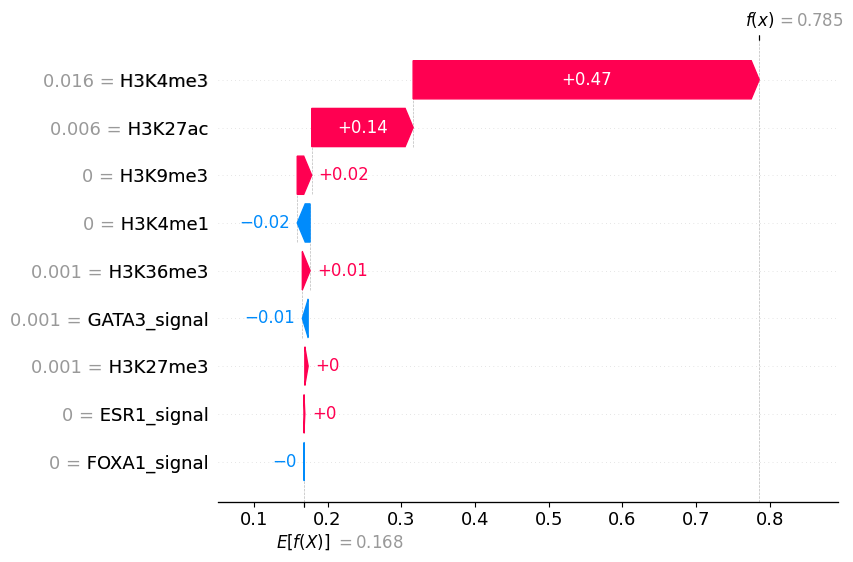

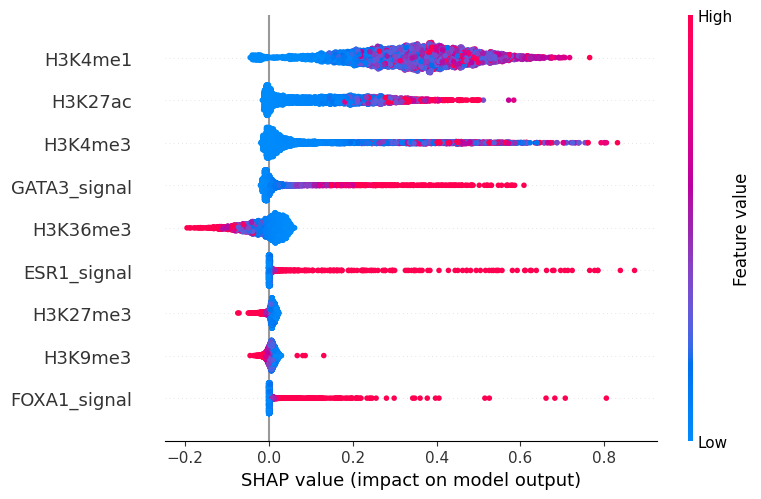

In [2]:
import numpy as np
import pandas as pd
import shap
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, precision_score, recall_score, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns

# **Step 1: Reload Dataset (Avoid Previous Code Conflicts)**
file_path = "/Users/faith/Desktop/BIO1018-Chromatin-Accessibility-ML/data/final_feature_matrix.csv"
df = pd.read_csv(file_path, sep=",", header=0)

# Ensure chromatin_state is numeric
df["chromatin_state"] = pd.to_numeric(df["chromatin_state"], errors="coerce")
df = df.dropna(subset=["chromatin_state"])
df["chromatin_state"] = df["chromatin_state"].astype(int)

# **Encode Chromosomes Numerically for LOCO Splits**
df["chromosome"] = df["chromosome"].astype("category")
chromosome_mapping = dict(enumerate(df["chromosome"].cat.categories))  
df["chromosome"] = df["chromosome"].cat.codes  

# **Select the Chromosome to Leave Out**
leave_out_chromosome = "chr1"
chrom_num = [num for num, name in chromosome_mapping.items() if name == leave_out_chromosome][0]

print(f"\nLeaving out {leave_out_chromosome} for testing...")

# **Split Train/Test Based on LOCO**
train_df = df[df["chromosome"] != chrom_num]
test_df = df[df["chromosome"] == chrom_num]

# **Check Class Distribution in Test Set**
print("\nTest Set Class Distribution (Actual Counts):")
print(test_df["chromatin_state"].value_counts())

# **Downsample Majority Class in Training Set (5× the Minority Class)**
majority_class = train_df[train_df["chromatin_state"] == 0]
minority_class = train_df[train_df["chromatin_state"] == 1]

if len(minority_class) > 0:
    n_majority = min(len(majority_class), 5 * len(minority_class))
else:
    n_majority = 10  

majority_downsampled = majority_class.sample(n=n_majority, random_state=42)
train_df_balanced = pd.concat([majority_downsampled, minority_class]).sample(frac=1, random_state=42)

# **Feature Columns**
histone_marks = ["H3K4me1", "H3K4me3", "H3K27ac", "H3K27me3", "H3K9me3", "H3K36me3"]
tf_signals = ["ESR1_signal", "FOXA1_signal", "GATA3_signal"]
all_features = histone_marks + tf_signals

# **Extract Features & Targets**
X_train = train_df_balanced[all_features]
y_train = train_df_balanced["chromatin_state"]
X_test = test_df[all_features]
y_test = test_df["chromatin_state"]

# **Normalize Features (No Data Leakage)**
scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# **Step 2: Train the Model with Final Hyperparameters**
input_layer = Input(shape=(X_train.shape[1],), name="Feature_Input")
dense = Dense(64, activation='relu')(input_layer)
dense = Dropout(0.3)(dense)
dense = Dense(32, activation='relu')(dense)
dense = Dropout(0.3)(dense)
output_layer = Dense(1, activation='sigmoid', name="Output")(dense)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=['accuracy'])

# **Train Model**
batch_size = 24
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train, 
    epochs=50, batch_size=batch_size,  
    validation_split=0.2, 
    class_weight={0:1, 1:2},
    callbacks=[early_stopping], verbose=1
)

# **Step 3: Get Model Predictions**
y_test_probs = model.predict(X_test, batch_size=batch_size).flatten()
threshold = 0.7
y_test_pred = (y_test_probs > threshold).astype(int)

# **Step 4: Identify False Positives (FPs)**
false_positives = np.where((y_test_pred == 1) & (y_test == 0))[0]  # Get FP indices
X_test_fp = X_test[false_positives] if len(false_positives) > 0 else None  # Extract FP feature data

print(f"False Positives Found: {X_test_fp.shape[0] if X_test_fp is not None else 0}")

# **Step 5: SHAP Analysis (Explain False Positives)**
if X_test_fp is not None and len(X_test_fp) > 0:
    explainer = shap.Explainer(model, X_train, feature_names=all_features)
    shap_values = explainer(X_test_fp)

    # **Plot SHAP Waterfall for a Random FP**
    shap.waterfall_plot(shap_values[0])  # First FP instance
    plt.show()

    # **Plot SHAP Summary Plot**
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_test_fp, feature_names=all_features)
else:
    print("No false positives found for SHAP analysis.")